# Reconstructing trees from ultrametric distances

In [150]:
'''
This module presents an algorithm for reconstructing
the ultrametric tree corresponding to a matrix of 
ultrametric distances. 

The algorithm is the one presented by Dan Gusfield in:

    http://web.cs.ucdavis.edu/~gusfield/ultraerrat/ultraerrat.html
    
Additional information can be found on his book:

    Algorithms on Strings, Trees, and Sequences.


Usage:

```python
# An ultrametric matrix
ultrametric = [ [0, 8, 8, 5, 3],
                [8, 0, 3, 8, 8],
                [8, 3, 0, 8, 8],
                [5, 8, 8, 0, 5],
                [3, 8, 8, 5, 0] ]
nodes = ['A', 'B', 'C', 'D', 'E']

# Get the tree
t = ultrametric_tree(ultrametric, nodes)
print(t)

    #         /-A
    #      /-|
    #   /-|   \-E
    #  |  |
    #--|   \-D
    #  |
    #  |   /-B
    #   \-|
    #      \-C
```
    

Algorithm description:

    "...here is another combinatorial algorithm that I claim is correct 
     and that does run in O(n^2) time. The algorithm is described in terms 
     of a graph G, based on matrix D, but it can be implemented without an 
     explicit graph.

     Let each row i of matrix D be represented by a node i in G, and each 
     edge (i,j) be given the value D(i,j). In O(n2) time, the algorithm 
     will find a very particular path in graph G:

        Set N equal to all the indices 1 through n; set L to the empty path; 
        set i to any node.

        Repeat n-1 times: begin remove i from N; find an index j in N such 
        that D(i,j) <= D(i,k) for any k in N. place edge (i,j) in the path L; 
        set i to j; end;

     What this produces is a path L of exactly n edges, and the algorithm 
     can be implemented in O(n2) time. It turns out that L is a minimum 
     spanning tree of G, but that fact is not needed.

     We will now use L to create the ultrametric tree recursively.

     Concentrate on an edge (p,q) in the path L with the largest edge weight 
     of all edges in L, and let P be the set of nodes at or to the left of p 
     in L, and let Q be the set of nodes at or to the right of q in L. The 
     fact that D is an ultrametric matrix implies that for any pair of nodes 
     (i,j) where i is in P and j is in Q, D(i,j) = D(p,q). One way to prove 
     this is by induction on the number of edges between i and j in L 
     (applying the ultrametric condition that in any triangle, the max of the 
     three edge weights is not unique). What this means is that in the 
     ultrametric tree we are building (and in any ultrametric tree for D), 
     any pair of leaves (i,j) where i is in P and j is in Q must have their 
     least common ancestor at the root of the ultrametric tree, and that root 
     must be labelled D(p,q).

     If there are k > 1 ties for the global max edge weight in L, then 
     removing those k edges creates k+1 subpaths of nodes, and applying the 
     above argument, any two nodes i and j which are in different subpaths 
     must have their least common ancestor at the root of the tree, which 
     again must be labeled D(p,q). Hence, any ultrametric tree T for D must 
     have exactly k+1 edges out of D, and the leaf set below any such edge 
     must be exactly the (distinct) set of nodes in one of the k+1 subpaths.

     No matter what k is, removing the k max weight edges in L, and 
     partitioning N, takes only O(n) time.

     To continue the description of the algorithm, we assume for convenience 
     that k = 1. Let LP and LQ denote the two subpaths created by removing 
     the max weight edge in L. Now we want to find an ultrametric tree for 
     set P and one for set Q; these two ultrametric trees will then be 
     attached to the root to creat the full ultrametric tree for D. But note 
     that we already have the needed paths LP and LQ that would be created if 
     we were to recursively apply the above method (clearly LP could result 
     if we applied the path building algorithm to P alone, and similarly for 
     LQ and Q). So we only need to find the max weight edge(s) in LP and the 
     max weight edge(s) in LQ. Those two edges can be found in O(n) total 
     time. Again, because the nodes were partitioned in the first step, this 
     time bound holds even for k > 1.

     Continuing, we build the ultrametric tree in O(n2) total time.

     Note that at each step of the algorithm, the node partitions that are 
     created, and the associated edges that are put into T, are forced. Hence 
     if D is an ultrametric matrix, the ultrametric tree T for D is unique.
    " - Dan Gusfield.

'''

import networkx as nx
import ete3 as ete


def ultrametric_tree(ultrametric, nodes):
    g = get_graph(ultrametric, nodes)
    P = get_path(g, ultrametric, nodes)
    t = path_to_tree(P)
    t.standardize()
    
    return t
# ---


def get_graph(ultrametric, nodes):
    "From an ultrametric matrix, get the weights graph."
    
    n = len(nodes) # Matrix dimensions
    
    # Add nodes
    g.add_nodes_from(nodes)
    
    # Add edge weights
    for i in range(n):
        for j in range(i+1, n):
            g.add_edge(nodes[i], nodes[j], weight=ultrametric[i][j])
            
    return g
# ---

def get_path(g, ultrametric, nodes):
    "From the weights graph, get the path."
    weight = weights_for(ultrametric, nodes)
    
    N = set(nodes)
    L = nx.Graph()
    i = N.pop()

    while(N):
        # Find a node j in N for which D(i,j) is max
        j,w = min([(node, weight(i, node)) for node in N],
                  key=(lambda x:x[-1]))
        # Place (i,j) in path L
        L.add_edge(i,j, weight=w)
        
        i = j
        N.remove(j)
        
    return L
# ---

def path_to_tree(P):    
    tree = ete.Tree()
    
    if len(P.edges) <= 1:
        # Edge case
        for v in P.nodes:
            tree.add_child(name=v)
    else:
        # Remove the edge with the maximum weight
        P = P.copy()
        edge, weight = max_edge_weight(P)
        P.remove_edge(*edge)
        
        # Do the same to the remaining subpaths
        for c in nx.connected_components(P):
            component = P.subgraph(c).copy()
            tree.add_child(path_to_tree(component))
            
    return tree
# ---

def weights_for(matrix, nodes):
    "Get the entries by node name."
    # Translate node names to indices
    to_indices = {node:i for i,node in enumerate(nodes)}
    
    def weight_fn(a,b):
        return matrix[to_indices[a]][to_indices[b]]
    
    return weight_fn
# ---

def max_edge_weight(L):
    "Return the edge with the largest weight."
    return max([(edge,weight) for *edge,weight in L.edges.data('weight')],
               key=lambda x: x[-1])
# ---

def draw_graph(g):
    "Display an edge-weighted graph."
    labels = nx.get_edge_attributes(g,'weight')
    nx.draw_networkx_edge_labels(g,
                                 nx.circular_layout(g),
                                 edge_labels=labels)
    nx.draw_circular(g, with_labels=True)
# ---

In [151]:
# An ultrametric matrix
ultrametric = [ [0, 8, 8, 5, 3],
                [8, 0, 3, 8, 8],
                [8, 3, 0, 8, 8],
                [5, 8, 8, 0, 5],
                [3, 8, 8, 5, 0] ]
nodes = ['A', 'B', 'C', 'D', 'E']

# Get the tree
t = ultrametric_tree(ultrametric, nodes)
print(t)

    #         /-A
    #      /-|
    #   /-|   \-E
    #  |  |
    #--|   \-D
    #  |
    #  |   /-B
    #   \-|
    #      \-C


         /-A
      /-|
   /-|   \-E
  |  |
--|   \-D
  |
  |   /-B
   \-|
      \-C


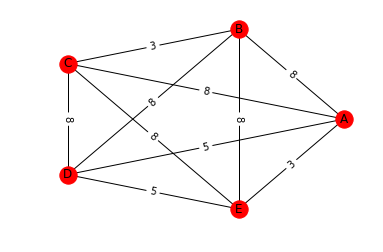

In [152]:
g = get_graph(ultrametric, nodes)
draw_graph(g)

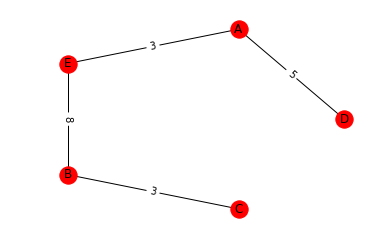

In [153]:
P = get_path(g, ultrametric, nodes)
draw_graph(P)

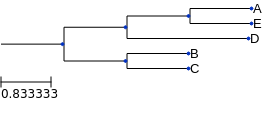

In [154]:
t = path_to_tree(P)
t.standardize()
t.render('%%inline')

# The Cavender-Farris-Neyman model

In [179]:
t = ete.Tree()

In [180]:
t.populate(10)
print(t)


         /-aaaaaaaaab
      /-|
     |   \-aaaaaaaaac
     |
   /-|      /-aaaaaaaaad
  |  |   /-|
  |  |  |   \-aaaaaaaaae
  |   \-|
  |     |   /-aaaaaaaaaf
  |      \-|
--|        |   /-aaaaaaaaag
  |         \-|
  |            \-aaaaaaaaah
  |
  |      /-aaaaaaaaai
  |   /-|
   \-|   \-aaaaaaaaaj
     |
      \-aaaaaaaaaa


In [197]:
import random as rnd
for i,node in enumerate(t.traverse()):
    node.name = i
    if i > 0:
        # Add a change probability >= 0.5
        node.add_feature('probability', rnd.random()/2)
        print(i, node.probability)
    else:
        # No probability of change before this
        node.add_feature('probability', 0) 

print(t)

1 0.09313436852357382
2 0.31294283648387616
3 0.4164909088403368
4 0.14076400291969898
5 0.27064852601847167
6 0.2712317623554814
7 0.3948716988252138
8 0.43139445382966496
9 0.40129616929190026
10 0.3172838107500926
11 0.4536611802512429
12 0.16797247570430207
13 0.12345886559563068
14 0.3230100860192188
15 0.3356180265873812
16 0.1177179794045789
17 0.29358912876463583
18 0.2533874338432059

         /-7
      /-|
     |   \-8
     |
   /-|      /-13
  |  |   /-|
  |  |  |   \-14
  |   \-|
  |     |   /-15
  |      \-|
--|        |   /-17
  |         \-|
  |            \-18
  |
  |      /-11
  |   /-|
   \-|   \-12
     |
      \-6


In [198]:
for leaf in t.iter_leaves():
    print(leaf.name, leaf.probability)

7 0.3948716988252138
8 0.43139445382966496
13 0.12345886559563068
14 0.3230100860192188
15 0.3356180265873812
17 0.29358912876463583
18 0.2533874338432059
11 0.4536611802512429
12 0.16797247570430207
6 0.2712317623554814


In [199]:
from collections import defaultdict

def swap(binary):
    if binary:
        return 0
    else:
        return 1
# ---
    
def random_test(probability):
    'Return True with a given probability, otherwise return False.'
    return (rnd.random() < probability)
# ---

sequence = defaultdict(list)
for leaf in t.iter_leaves():
    path_from_root = reversed(leaf.get_ancestors())
    # Follow path stochastically 
    character = 1
    for node in path_from_root: 
        probability = node.probability
        if random_test(probability):
            character = swap(character)
    # Save character's final state
    sequence[leaf.name].append(character)
sequence

defaultdict(list,
            {6: [1],
             7: [0],
             8: [0],
             11: [0],
             12: [0],
             13: [0],
             14: [0],
             15: [1],
             17: [0],
             18: [1]})

In [188]:
t.probability

AttributeError: 'TreeNode' object has no attribute 'probability'

In [256]:
"""
Module implementing the Cavender-Farris-Neymann stochastic tree model.

The model is based on the description by the book:
    
    Computational Phylogenetics.
      An introduction to designing methods for phylogeny estimation.
      -- by Tandy Warnow
      
Usage:

```python
# Create a new empty tree.
cfn = CFN_Tree()

# Branch randomly until you have 5 leaves.
cfn.populate(5)

    # Node: 0, node probability: 0
    # Node: 1, node probability: 0.45158852704268865
    # Node: 2, node probability: 0.11424818655999902
    # Node: 3, node probability: 0.4264051970154286
    # Node: 4, node probability: 0.459742963797842
    # Node: 5, node probability: 0.3654757150714647
    # Node: 6, node probability: 0.4320439824130711
    # Node: 7, node probability: 0.4988182678649847
    # Node: 8, node probability: 0.11885743478646316
    #
    #          /-7
    #       /-|
    #    /-|   \-8
    #   |  |
    # --|   \-4
    #   |
    #   |   /-5
    #    \-|
    #       \-6

# Evolve 5 traits through the tree
sequences = cfn.evolve_traits([1,1,1,1,1])
print(sequences)

    # {3: [1, 0, 0, 0, 1],
    #  5: [1, 1, 1, 1, 1],
    #  6: [1, 1, 0, 1, 1],
    #  7: [1, 0, 0, 1, 1],
    #  8: [1, 1, 1, 1, 1]}

```

The CFN model in words from the book:

"The Cavender-Farris-Neyman (CFN) model describes how a trait (which 
 can either be present or absent) evolves down a tree (Cavender, 
 1978; Farris, 1973; Neyman, 1971).

 ...a CFN model has a rooted binary tree T (i.e., a tree in which 
 every node is either a leaf or has two children) with numerical 
 parameters that describe the evolutionary process of a trait. Under 
 the CFN model, the probability of absence (0) or presence (1) is the 
 same at the root, but the state can change on the edges (also called 
 branches) of the tree. Thus, we associate a parameter p(e) to every 
 edge e in the tree, where p(e) denotes the probability that the 
 endpoints of the edge e have different states. In other words, p(e)
 is the probability of changing state (from 1 to 0, or vice-versa).

 Under  the  CFN  model,  a  trait  (which  is  also  called  a  
 “character”)  evolves  down  the tree under this random process, and 
 hence attains a state at every node in the tree, and in particular 
 at the leaves of the tree. You could write a computer program for a 
 CFN model tree that would generate 0s and 1s at the leaves of the 
 tree; thus, CFN is a generative model.
 
 Each time you ran the program you would get another pattern of 0s and 
 1s at the leaves of the tree. Thus, if you repeated the process 10 
 times, each time independently generating a new trait down the tree, 
 you would produce sequences of length 10 at the leaves of the tree."
    -- from the book.
"""

import ete3 as ete
import random as rnd
from collections import defaultdict


def swap(binary):
    if binary:
        return 0
    else:
        return 1
# ---


def random_test(probability):
    'Return True with a given probability, otherwise return False.'
    return (rnd.random() < probability)
# ---


class CFN_Tree(ete.Tree):
    "A Cavender-Farris-Neymann stochastic tree model."
    
    def populate(self, n):
        'Populate the tree with nodes and change probabilities.'
        # Populate the usual way
        super().populate(n)
        # Change names and add probabilities
        for i,node in enumerate(self.traverse()):
            node.name = i
            if i > 0:
                # Add a change probability >= 0.5
                node.add_feature('probability', rnd.random()/2)
            else:
                # No probability of change before this
                node.add_feature('probability', 0)
            print(f"Node: {i}, node probability: {node.probability}")
        print(self)
    # ---        
        
    def total_nodes(self):
        return len(list(self.traverse()))
    # ---
    
    def evolve_traits(self, traits):
        "Evolve the binary traits through the tree."
        # The sequences generated
        sequences = defaultdict(list)
        for leaf in self.iter_leaves():
            path_from_root = list(reversed(leaf.get_ancestors()))
            path_from_root.append(leaf)
            # Evolve each trait
            for trait in traits:
                # Follow path stochastically 
                final_trait = self.trait_traverse(path_from_root, trait)
                # Save character's final state
                sequences[leaf.name].append(final_trait)
        return dict(sequences)
    # ---
            
    def trait_traverse(self, path_from_root, init):
        # Follow path stochastically 
        trait = init
        for node in path_from_root: 
            probability = node.probability
            if random_test(probability):
                trait = swap(trait)
        # Return character's final state
        return trait
    # ---

In [257]:
len(list(t.traverse()))

19

In [258]:
cfn = CFN_Tree()

In [259]:
cfn.populate(5)

Node: 0, node probability: 0
Node: 1, node probability: 0.27673670727553307
Node: 2, node probability: 0.24989681937451907
Node: 3, node probability: 0.1006805620895716
Node: 4, node probability: 0.2607858647601118
Node: 5, node probability: 0.07046503659914632
Node: 6, node probability: 0.29423009187238663
Node: 7, node probability: 0.10092588563768062
Node: 8, node probability: 0.2728184149718495

      /-3
   /-|
  |  |   /-7
  |   \-|
--|      \-8
  |
  |   /-5
   \-|
      \-6


In [260]:
sequences = cfn.evolve_traits([1,1,1,1,1])
sequences

{3: [1, 0, 0, 0, 1],
 5: [1, 1, 1, 1, 1],
 6: [1, 1, 0, 1, 1],
 7: [1, 0, 0, 1, 1],
 8: [1, 1, 1, 1, 1]}